# Model

## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras

import numpy as np

import pickle

from sklearn import svm

import matplotlib.pyplot as plt

In [2]:
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data loading

We load the mffcs data previously preprocessed.

In [3]:
with open('mfccs.txt', 'rb') as f:
    mfccs = pickle.load(f)

In [4]:
X = mfccs['X']
y = mfccs['y']

In [5]:
np.sum(y) / len(y)

0.5014693171996543

We can notice that the data is pretty well balanced and thus permits us to use accuracy as metric

## training and test set

We split the data in 2 parts, 80% for training and 20% for testing.

In [6]:
# We start by mixing up the data
random_mask = np.arange(X.shape[0])
np.random.shuffle(random_mask)
X = X[random_mask]
y = y[random_mask]

In [7]:
sep = 0.8
cutoff = int(X.shape[0] * 0.8)
X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

## Building the models

Helper functions to plot the intermediate results

In [8]:
def plot_loss(history):
    train_loss = history['loss']
    test_loss = history['val_loss']

    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(('train','test'))
    plt.show()

def plot_accuracy(history):
    train_acc = history['binary_accuracy']
    test_acc = history['val_binary_accuracy']

    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.legend(('train','test'))
    plt.show()

In [9]:
class Models:
    """
    This class implements various models to detect genders
    """
    def __init__(self, mode = 'log_reg'):
        """
        mode : possible values are log_reg, svm, mlp or cnn
        """
        self.mode = mode
    
    def compile_(self, kernel = 'rbf', C = 1.0, activation_function = 'relu', n_hidden_layers = 3, depth_layer = 24, lr = 0.0001):
        """
        builds the model when called according to the given mode.
        
        lr : the initial learning rate
        
        SVM:
            kernel : possible values are 'rbf' and 'poly' (more on sklearn API). Determines the kernel function.
            C : strictly positive value. Regularization parameter.
        
        MLP:
            n_hidden_layer : number of hidden layers in the MLP
            
        MLP & CNN:
            activation_function : the activation functions to use for the hidden layers
            depth_layer : number of neurons of the fully connected layers
        
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        if self.mode == 'log_reg':
            """
            Flatten then logistic regression
            """
            model = tf.keras.Sequential()
            model.add(tensorflow.keras.layers.Flatten())
            model.add(tensorflow.keras.layers.Dense(1, activation = 'sigmoid'))
            model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
        
        elif self.mode == 'mlp':
            """
            Fully connected neural network
            """
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Flatten())
            for _ in range(n_hidden_layers):
                model.add(tf.keras.layers.Dense(depth_layer, activation = activation_function))
            model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
            model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
        
        elif self.mode == 'cnn':
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Conv2D(16, (3,3), activation = activation_function))
            model.add(tf.keras.layers.MaxPooling2D((1,2)))
            model.add(tf.keras.layers.Conv2D(32, (3,3), activation = activation_function))
            model.add(tf.keras.layers.Flatten())
            model.add(tf.keras.layers.Dense(depth_layer, activation = activation_function))
            model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
            model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
            
        elif self.mode == 'svm':
            """
            Support Vector Machine using sklearn
            """
            model = svm.SVC(
                C = C,
                kernel = kernel,
                gamma = 'scale',
                verbose = True,
            )
            
        self.model = model

    
    def train(self, X_train, y_train, X_val, y_val, epochs = 50, batch_size = 32, plot = True, verbose = 1):
        """
        X_train : list of mfccs in 2D
        y_train : list of labels of X_train
        X_val : list of mfccs for testing
        y_val : list of testing labels
        epochs : number of epochs to run
        batch_size : number of samples per iteration to perform GD on
        plot : if True will plot the results at the end of training
        verbose : if 1 will output information while training
        """
        if self.mode == 'svm':
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
            history = self.model.fit(
                X_train,
                y_train
            )
            if verbose == 1:
                print(
                r"""training accuracy: {}
                test accuracy : {}""".format(self.model.score(X_train, y_train), self.model.score(X_val, y_val)))
            
            history = self.model.score(X_val, y_val)
            
        else:
            if self.mode == 'cnn':
                # for cnns we have to add a new dimention as input for the required tensors and transpose the samples
                X_train = np.transpose(X_train, (0, 2, 1))
                X_val = np.transpose(X_val, (0, 2, 1))
                X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
                X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
                
            history = self.model.fit(
                X_train,
                y_train,
                batch_size = batch_size, 
                epochs = epochs,
                verbose = verbose,
                validation_data = (X_val, y_val),
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(patience = 3),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-6)
                ]
            )
            if plot:
                plot_loss(history.history)
                plot_accuracy(history.history)

        return history


## Logistic regression

In [38]:
learning_rates = np.arange(0, 0.001, 0.00005)[1:]

In [39]:
histories = {}
for lr in learning_rates:
    model = Models(mode = 'log_reg')
    model.compile_(lr = lr)
    h = model.train(X_train, y_train, X_test, y_test, plot = False, verbose = 0)
    histories[lr] = h.history

In [40]:
data = []
for lr in learning_rates:
    data.append([lr, histories[lr]['val_binary_accuracy'][-1]])
data = np.array(data)

In [41]:
import pandas as pd

pd.DataFrame(data, np.arange(19)+1, ['learning_rate', 'test set accuracy'])

,learning_rate,test set accuracy
1,0.00005,0.843129
2,0.00010,0.855229
3,0.00015,0.872083
4,0.00020,0.875540
5,0.00025,0.879430
6,0.00030,0.882887
7,0.00035,0.874244
8,0.00040,0.883319
9,0.00045,0.872947
10,0.00050,0.880294


In [53]:
best_lr = round(learning_rates[int(np.argmax(data[:,1]))], 5)
best_val = round(np.max(data[:,1]), 4)

In [54]:
print('The best learning rate is of {} for an accuracy of {}'.format(best_lr, best_val))

The best learning rate is of 0.0009 for an accuracy of 0.8915


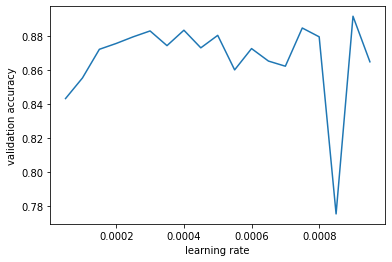

In [55]:
plt.figure()
plt.plot(data[:,0], data[:,1])
plt.xlabel('learning rate')
plt.ylabel('validation accuracy')
plt.show()

## MLP

In [18]:
num_layers = [2,3]
depth_layers = [16, 32]
learning_rates = np.arange(0, 0.001, 0.00005)[1:]

data = []

for n in num_layers:
    for d in depth_layers:
        histories = {}
        for lr in learning_rates:
            model = Models(mode = 'mlp')
            model.compile_(n_hidden_layers = n, depth_layer = d, lr = lr)
            h = model.train(X_train, y_train, X_test, y_test, plot = False, verbose = 0)
            histories[lr] = h.history['val_binary_accuracy'][-1]
        
        data.append(histories)

In [19]:
dfs = []
i = 0
for n in num_layers:
    for d in depth_layers:
        l = []
        for lr in learning_rates:
            l.append(data[i][lr])
        df = pd.DataFrame(l, np.arange(len(learning_rates))+1, ['test set accuracy'])
        df['learning_rates'] = learning_rates
        dfs.append(df)
        i+=1

In [20]:
print('num_layers = {}; depth_layers = {}'.format(num_layers[0], depth_layers[0]))
dfs[0]

num_layers = 2; depth_layers = 16


,test set accuracy,learning_rates
1,0.891530,0.00005
2,0.890666,0.00010
3,0.868626,0.00015
4,0.885912,0.00020
5,0.900605,0.00025
6,0.886344,0.00030
7,0.888505,0.00035
8,0.894987,0.00040
9,0.889801,0.00045
10,0.851772,0.00050


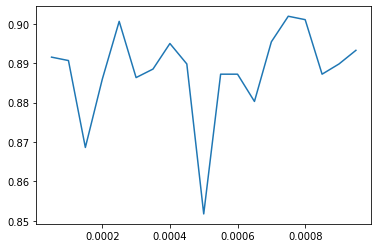

In [21]:
plt.figure()
plt.plot(dfs[0]['learning_rates'], dfs[0]['test set accuracy'])
plt.show()

In [22]:
max0 = np.max(dfs[0]['test set accuracy'])
max0

0.9019014835357666

In [23]:
print('num_layers = {}; depth_layers = {}'.format(num_layers[0], depth_layers[1]))
dfs[1]

num_layers = 2; depth_layers = 32


,test set accuracy,learning_rates
1,0.885048,0.00005
2,0.893258,0.00010
3,0.876405,0.00015
4,0.895419,0.00020
5,0.895851,0.00025
6,0.888937,0.00030
7,0.883751,0.00035
8,0.895419,0.00040
9,0.869490,0.00045
10,0.899741,0.00050


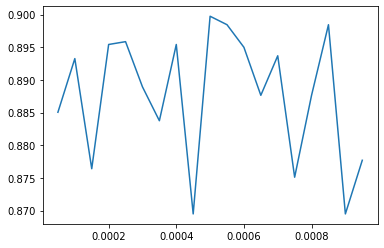

In [24]:
plt.figure()
plt.plot(dfs[1]['learning_rates'], dfs[1]['test set accuracy'])
plt.show()

In [25]:
max1 = np.max(dfs[1]['test set accuracy'])
max1

0.8997406959533691

In [26]:
print('num_layers = {}; depth_layers = {}'.format(num_layers[1], depth_layers[0]))
dfs[2]

num_layers = 3; depth_layers = 16


,test set accuracy,learning_rates
1,0.885912,0.00005
2,0.890666,0.00010
3,0.897148,0.00015
4,0.895419,0.00020
5,0.904062,0.00025
6,0.898012,0.00030
7,0.901469,0.00035
8,0.895851,0.00040
9,0.898444,0.00045
10,0.863872,0.00050


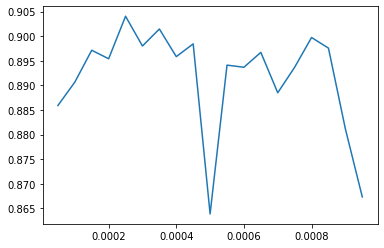

In [27]:
plt.figure()
plt.plot(dfs[2]['learning_rates'], dfs[2]['test set accuracy'])
plt.show()

In [28]:
max2 = np.max(dfs[2]['test set accuracy'])
max2

0.9040622115135193

In [29]:
print('num_layers = {}; depth_layers = {}'.format(num_layers[1], depth_layers[1]))
dfs[3]

num_layers = 3; depth_layers = 32


,test set accuracy,learning_rates
1,0.894987,0.00005
2,0.889801,0.00010
3,0.890233,0.00015
4,0.885048,0.00020
5,0.900605,0.00025
6,0.890233,0.00030
7,0.877269,0.00035
8,0.895851,0.00040
9,0.905359,0.00045
10,0.899741,0.00050


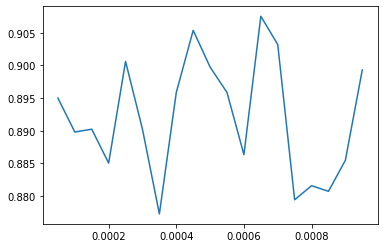

In [30]:
plt.figure()
plt.plot(dfs[3]['learning_rates'], dfs[3]['test set accuracy'])
plt.show()

In [31]:
max3 = np.max(dfs[3]['test set accuracy'])
max3

0.9075194597244263

In [32]:
np.max([max0, max1, max2, max3])

0.9075194597244263

## CNN

In [56]:
activations = ['relu', 'tanh', 'selu']
learning_rates = np.arange(0, 0.001, 0.00005)[1:]

data = []

for activation_function in activations:
    histories = {}
    for lr in learning_rates:
        model = Models(mode = 'cnn')
        model.compile_(activation_function = activation_function, lr = lr)
        h = model.train(X_train, y_train, X_test, y_test, plot = False, verbose = 0)
        histories[lr] = h.history['val_binary_accuracy'][-1]

    data.append(histories)

In [57]:
dfs = []

for d in data:
    l = []
    df = pd.DataFrame()
    for lr in learning_rates:
        l.append(d[lr])
    df['learning_rates'] = learning_rates
    df['validation accuracy'] = l
    dfs.append(df)

In [64]:
print('activation function: {}'.format(activations[0]))
dfs[0]

activation function: relu


,learning_rates,validation accuracy
0,0.00005,0.877269
1,0.00010,0.914866
2,0.00015,0.904494
3,0.00020,0.884615
4,0.00025,0.906223
5,0.00030,0.902766
6,0.00035,0.876405
7,0.00040,0.909680
8,0.00045,0.888937
9,0.00050,0.901037


In [67]:
np.max(dfs[0]['validation accuracy'])

0.914866030216217

In [70]:
print('activation function: {}'.format(activations[1]))

dfs[1]

activation function: tanh


,learning_rates,validation accuracy
0,0.00005,0.887640
1,0.00010,0.887208
2,0.00015,0.890233
3,0.00020,0.894123
4,0.00025,0.895851
5,0.00030,0.883751
6,0.00035,0.894987
7,0.00040,0.899309
8,0.00045,0.890666
9,0.00050,0.891962


In [72]:
np.max(dfs[1]['validation accuracy'])

0.8993085622787476

In [66]:
print('activation function: {}'.format(activations[2]))

dfs[2]

activation function: selu


,learning_rates,validation accuracy
0,0.00005,0.870354
1,0.00010,0.866465
2,0.00015,0.904494
3,0.00020,0.906223
4,0.00025,0.895419
5,0.00030,0.907952
6,0.00035,0.918755
7,0.00040,0.906655
8,0.00045,0.903630
9,0.00050,0.910545


In [71]:
np.max(dfs[2]['validation accuracy'])

0.9191875457763672

## SVM hyperparameters

In [68]:
kernels = ['poly', 'rbf']

C = np.arange(0, 2, 0.1)[1:]

data = []

for kernel in kernels:
    histories = {}
    for c in C:
        model = Models(mode = 'svm')
        model.compile_(kernel = kernel, C = c)
        h = model.train(X_train, y_train, X_test, y_test, plot = False, verbose = 0)
        histories[c] = h
        
    data.append(histories)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [73]:
dfs = []

for d in data:
    l = []
    df = pd.DataFrame()
    for c in C:
        l.append(d[c])
    df['learning_rates'] = learning_rates
    df['validation accuracy'] = l
    dfs.append(df)

In [82]:
print('kernel: polynomial')
dfs[0]

kernel: polynomial


,learning_rates,validation accuracy
0,0.00005,0.865601
1,0.00010,0.880726
2,0.00015,0.888073
3,0.00020,0.890233
4,0.00025,0.893258
5,0.00030,0.893691
6,0.00035,0.894555
7,0.00040,0.894123
8,0.00045,0.894987
9,0.00050,0.898012


In [79]:
np.max(dfs[0]['validation accuracy'])

0.9014693171996543

In [81]:
print('kernel: rbf')

dfs[1]

kernel: rbf


,learning_rates,validation accuracy
0,0.00005,0.881158
1,0.00010,0.889369
2,0.00015,0.894987
3,0.00020,0.893691
4,0.00025,0.898012
5,0.00030,0.900605
6,0.00035,0.900173
7,0.00040,0.901469
8,0.00045,0.902334
9,0.00050,0.904062


In [80]:
np.max(dfs[1]['validation accuracy'])

0.9066551426101987